In [50]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [51]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)

In [52]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [53]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [54]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [55]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [56]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category2

# Remove Outliers

In [57]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(23)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [58]:
# Removes the date column from index, and makes the index start from 0 for the first observation
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])

# Adding Lagged Variables

In [59]:
lags = [1,2,3,4]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3','lag4']
category = category[selected_columns]

# Train - Test Split

In [60]:
X = category.drop(category.columns[0], axis=1)
y = category.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Creating a new dataframe for visualizing the real data versus the models predictions
Category = pd.concat([y_train, y_test])
Category.reset_index(drop=True, inplace=True)
print(len(Category))
y_test

19


5      63250.0
18     95800.0
6      37000.0
11    108500.0
Name: Amount, dtype: float64

# Model Selection

In [61]:
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

# PCA

In [62]:
n_components = len(lags)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_poly)
X_test_pca = pca.fit_transform(X_test_poly)

# Fit the model

In [63]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

# Evaluate Model

In [64]:
y_pred = model.predict(X_test_pca)

In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error : {mse}')
print(f'Root Mean Squared Error : {rmse}')
print(f'Mean Absolute Percenage Error : {mape}')

Mean Squared Error : 5500447263.936239
Root Mean Squared Error : 74165.0002624974
Mean Absolute Percenage Error : 0.8823488740971098


In [66]:
index_start = 15
index = range(index_start, index_start + len(y_pred))
df = pd.DataFrame(y_pred, index=index, columns=['Values'])
Category = pd.DataFrame(Category)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

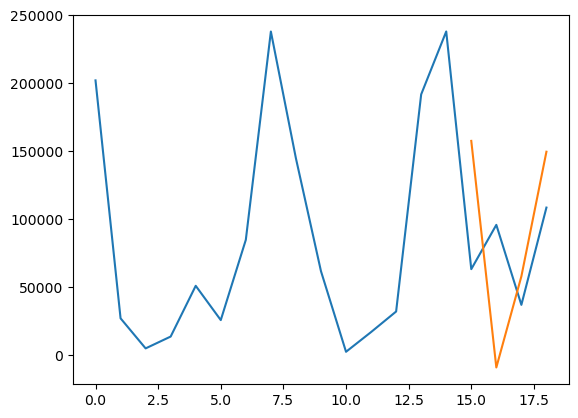

In [67]:
# The graph is different because the order of the original data was shuffled, now I'm comparing the shufled data to the model's
# predciton o the shuffled data

plt.plot(Category, label='Original Data')
plt.plot(df)
plt.xlabel

# Save the model

In [68]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)

In [69]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(model2, f)
# result = model2.fit()
# print(result.summary())

In [70]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)
# Takes 3 target lags

# Make Time Series Predictions

In [71]:
# data = {
#     'lag1': [546350.0],
#     'lag2': [752250.0],
#     'lag3': [1050750.0],
# #     'lag4': [1148263.0],
# #     'target_lag_5': [1327412.0]
# }

# df = pd.DataFrame(data)
# future_data_poly = poly_features.transform([[df]])
# future_data_pca = pca.transform(future_data_poly)
# predict = model.predict(future_data_pca)
# predict